CUDA Convolutional Sparse Coding
================================

This example demonstrates the use of the interface to the CUDA CSC solver extension package, with a test for the availablity of a GPU that runs the Python version of the CSC solver if one is not available, or if the extension package is not installed.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
plot.config_notebook_plotting()
from sporco import cuda
from sporco.admm import cbpdn
import sporco.linalg as spl
import sporco.metric as spm

# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
from contextlib import contextmanager
@contextmanager
def null_context_manager():
    yield
if util.in_notebook():
    try:
        from wurlitzer import sys_pipes
    except:
        sys_pipes = null_context_manager
else:
    sys_pipes = null_context_manager

Load example image.

In [2]:
img = util.ExampleImages().image('barbara.png', scaled=True, gray=True,
                                 idxexp=np.s_[10:522, 100:612])

Highpass filter example image.

In [3]:
npd = 16
fltlmbd = 5
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load dictionary.

In [4]:
D = util.convdicts()['G:12x12x36']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [5]:
lmbda = 1e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False})

If GPU available, run CUDA CBPDN solver, otherwise run standard Python version.

In [6]:
if cuda.device_count() > 0:
    print('GPU found: running CUDA solver')
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdn(D, sh, lmbda, opt)
    t = tm.elapsed()
else:
    print('GPU not found: running Python solver')
    c = cbpdn.ConvBPDN(D, sh, lmbda, opt)
    X = c.solve().squeeze()
    t = c.timer.elapsed('solve')
print('Solve time: %.2f s' % t)

GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     r         s         ρ
----------------------------------------------------------------
   1  8.68e+01  2.17e+00  8.47e+03  6.42e-01  8.14e-01  1.50e+00
   2  7.71e+01  3.71e+00  7.34e+03  3.43e-01  5.44e-01  1.50e+00
   3  8.23e+01  3.03e+00  7.93e+03  3.11e-01  3.70e-01  1.16e+00
   4  7.22e+01  3.01e+00  6.92e+03  2.59e-01  2.61e-01  1.03e+00
   5  6.21e+01  3.14e+00  5.89e+03  2.02e-01  1.94e-01  1.03e+00
   6  5.86e+01  3.26e+00  5.54e+03  1.58e-01  1.45e-01  1.03e+00
   7  5.49e+01  3.35e+00  5.16e+03  1.26e-01  1.23e-01  1.03e+00
   8  5.24e+01  3.39e+00  4.90e+03  1.03e-01  1.05e-01  1.03e+00
   9  5.15e+01  3.37e+00  4.81e+03  8.57e-02  9.21e-02  1.03e+00
  10  4.96e+01  3.36e+00  4.63e+03  7.29e-02  8.26e-02  1.03e+00
  11  4.77e+01  3.37e+00  4.43e+03  6.30e-02  7.28e-02  1.03e+00
  12  4.67e+01  3.39e+00  4.33e+03  5.81e-02  6.49e-02  9.37e-01
  13  4.58e+01  3.41e+00  4.24e+03  5.09e-02  5.76e-02  9.37e-01
  14  4.51e+01  3.42e+00  4.16e+

Solve time: 1.50 s


Reconstruct the image from the sparse representation.

In [7]:
shr = np.sum(spl.fftconv(D, X), axis=2)
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % spm.psnr(img, imgr))

Reconstruction PSNR: 44.76dB



Display representation and reconstructed image.

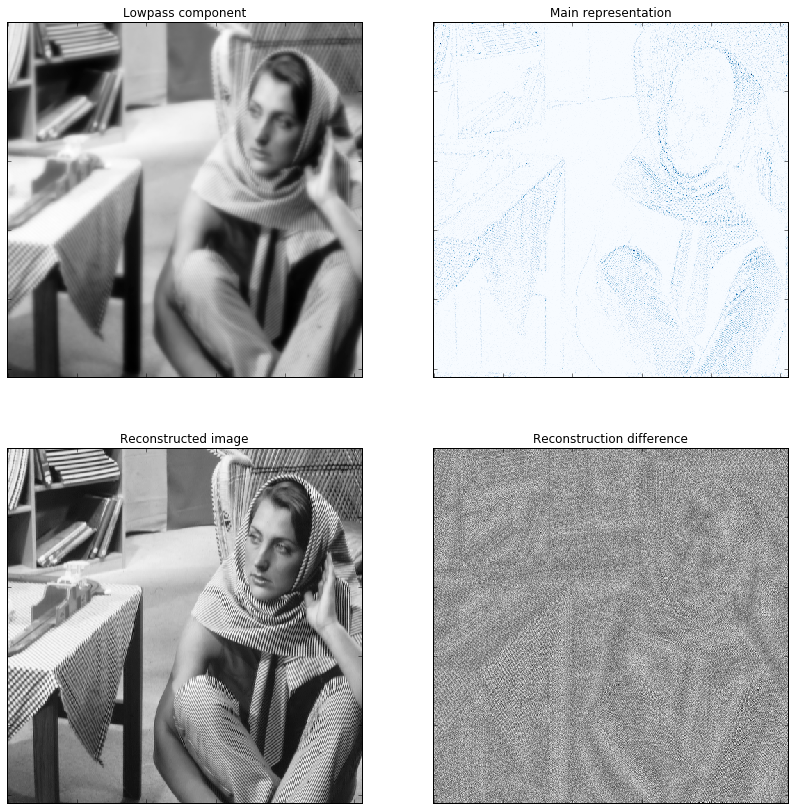

In [8]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sl, fig=fig, title='Lowpass component')
plot.subplot(2, 2, 2)
plot.imview(np.sum(abs(X), axis=2).squeeze(), fig=fig,
            cmap=plot.cm.Blues, title='Main representation')
plot.subplot(2, 2, 3)
plot.imview(imgr, fig=fig, title='Reconstructed image')
plot.subplot(2, 2, 4)
plot.imview(imgr - img, fig=fig, fltscl=True,
            title='Reconstruction difference')
fig.show()